# Importing Necessary Packages for Basic Demonstration of Data  

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html 

In [1]:
import numpy as np  
import pandas as pd 
import math

In [2]:
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#Demonstrates Display of dataframe in a better way 
from IPython.display import display, HTML

# Training and Test Data Subset 

In [4]:
import random 
random.seed(1)

In [5]:
def subsetData(df, percentage): 
    msk = np.random.rand(len(df)) < percentage
    train = df[msk]
    test = df[~msk]
    return train, test

# Choosing Training & Test data 

In [6]:
def chooseData(columnName, df):
    selectedData = df[columnName].values
    return selectedData

# Tokenizing text with scikit-learn

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
def tokenizeText(train_x, test_x):
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train_x)
    tfidf_transformer = TfidfTransformer()
    train_x_tfidf = tfidf_transformer.fit_transform(train_counts)
    test_counts = count_vect.transform(test_x)
    test_x_tfidf = tfidf_transformer.transform(test_counts)
    
    return count_vect, train_counts, tfidf_transformer, train_x_tfidf, test_counts, test_x_tfidf

# Training a Classifier

In [10]:
from sklearn.naive_bayes import MultinomialNB

In [11]:
def trainClassifier(train_x_tfidf, train_y, test_x_tfidf):
    clf = MultinomialNB().fit(train_x_tfidf, train_y)
    predicted = clf.predict(test_x_tfidf)
    #for test_row, cluster in zip(test_x, predicted): 
    #print('%r => %s' % (test_row, train_y[cluster]))
    
    return clf, predicted

# Evaluation of the Performance on the Test Set

In [12]:
def evaluateTestPerformance(predicted, test_y):
    print("The test has an accuracy of: ")
    print((np.mean(predicted == test_y)))

# Visualizing The Results
https://buhrmann.github.io/tfidf-analysis.html

In [13]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [14]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [15]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [16]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [17]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right= 10, left=0.15, top=0.8, wspace=0.52)
    plt.show()

In [18]:
def visualizeTfidf(count_vect, train_x_tfidf, train_y):
    features=count_vect.get_feature_names()
    dfs = top_feats_by_class(train_x_tfidf, train_y, features)
    plot_tfidf_classfeats_h(dfs)

In [19]:
pd.set_option('display.max_columns', None)

# Looking at District Description 

In [20]:
def analyzeTfidf(train_x, test_x, train_y, test_y, centroidLabels):
    tokenizeInfo = tokenizeText(train_x, test_x)
    count_vect  = tokenizeInfo[0]
    train_counts  = tokenizeInfo[1]
    tfidf_transformer  = tokenizeInfo[2]
    train_x_tfidf  = tokenizeInfo[3]
    test_counts  = tokenizeInfo[4]
    test_x_tfidf  = tokenizeInfo[5]
    classifierInfo  = trainClassifier(train_x_tfidf, train_y, test_x_tfidf)
    clf  = classifierInfo[0]
    predicted  = classifierInfo[1]
    evaluateTestPerformance(predicted, test_y)
    visualizeTfidf(count_vect, train_x_tfidf, train_y)
    display(centroidLabels)

In [21]:
def importClusters(datasetFilePath):
    clusters = pd.read_csv(datasetFilePath)
    clusters = clusters.drop(['Unnamed: 0', 'index'], axis =1 )
    print(clusters.head())
    print(clusters.shape)
    
    return clusters

In [48]:
def importClusters_2(datasetFilePath):
    clusters = pd.read_csv(datasetFilePath)
    clusters = clusters.drop(['Unnamed: 0'], axis =1 )
    print(clusters.head())
    print(clusters.shape)
    
    return clusters

In [31]:
localPath = "../../../Project/Unsupervised-MachineLearning/finalProject/"

In [71]:
def getTfidf(year):
    clusters = importClusters(localPath + "year" + str(year) + "_10clusters.csv")
    centroids = importClusters(localPath + "year" + str(year) + "_10clusterCentroids.csv")
    splitData = subsetData(clusters, 0.7)
    train = splitData[0]
    test = splitData[1]
    train_cluster = chooseData('clusters_10', train) 
    test_cluster = chooseData('clusters_10', test)
    train_dscrptn = chooseData('Description', train)
    test_dscrptn = chooseData('Description', test)
    train_location = chooseData('Location Description', train)
    test_location = chooseData('Location Description', test)
    train_pType = chooseData('Primary Type', train) 
    test_pType = chooseData('Primary Type', test)
    train_district = chooseData('District', train).astype('str')
    test_district = chooseData('District', test).astype('str')
    train_day = chooseData('Day', train).astype('str')
    test_day = chooseData('Day', test).astype('str')
    train_hour = chooseData('Hour', train).astype('str')
    test_hour = chooseData('Hour', test).astype('str')
    print("Description")
    analyzeTfidf(train_dscrptn, test_dscrptn, train_cluster, test_cluster, centroids)
    print("Location Description")
    analyzeTfidf(train_location, test_location, train_cluster, test_cluster, centroids)
    print("Primary Type")
    analyzeTfidf(train_pType, test_pType, train_cluster, test_cluster, centroids)
    print("District")
    analyzeTfidf(train_district, test_district, train_cluster, test_cluster, centroids)
    print("Day")
    analyzeTfidf(train_day, test_day, train_cluster, test_cluster, centroids)
    print("Hour")
    analyzeTfidf(train_hour, test_hour, train_cluster, test_cluster, centroids)

   IUCR                Primary Type                     Description  \
0  0266         CRIM SEXUAL ASSAULT                       PREDATORY   
1  1753  OFFENSE INVOLVING CHILDREN   SEX ASSLT OF CHILD BY FAM MBR   
2  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   
3  1754  OFFENSE INVOLVING CHILDREN  AGG SEX ASSLT OF CHILD FAM MBR   
4  1563                 SEX OFFENSE           CRIMINAL SEXUAL ABUSE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0            RESIDENCE   True     True       5.0  2001.0      1    1    11   
1            RESIDENCE   True    False       8.0  2001.0      1    1     0   
2                OTHER  False    False       9.0  2001.0      1    1     0   
3            RESIDENCE   True    False       7.0  2001.0      6   16     8   
4            RESIDENCE  False    False      15.0  2001.0      6    1     8   

   index.1  clusters_10  
0        0            0  
1        1            4  
2        2            8  


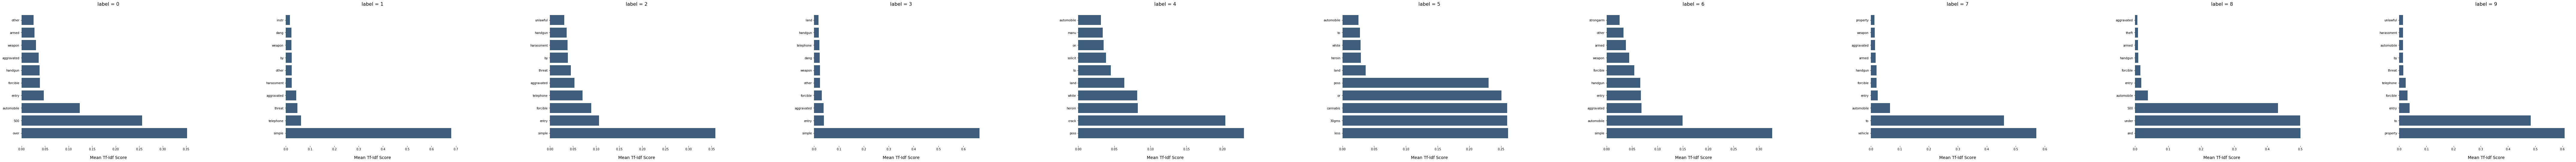

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,810,THEFT,OVER $500,STREET,False,False,5.0,2001.0,6,29,22
1,460,BATTERY,SIMPLE,RESIDENCE,False,True,25.0,2001.0,7,21,21
2,560,ASSAULT,SIMPLE,RESIDENCE,False,False,7.0,2001.0,2,6,17
3,460,BATTERY,SIMPLE,RESIDENCE,False,False,18.0,2001.0,12,4,9
4,2027,NARCOTICS,POSS: CRACK,STREET,True,False,2.0,2001.0,2,26,19
5,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,7.0,2001.0,4,18,20
6,560,ASSAULT,SIMPLE,STREET,False,False,14.0,2001.0,11,20,16
7,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,3.0,2001.0,5,6,0
8,820,THEFT,$500 AND UNDER,STREET,False,False,8.0,2001.0,1,19,15
9,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,10.0,2001.0,10,1,21


Location Description
The test has an accuracy of: 
0.275049841679


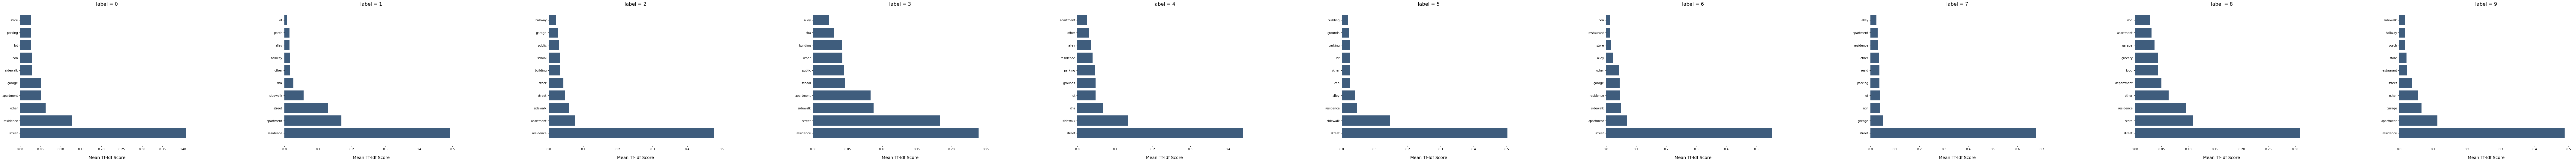

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,810,THEFT,OVER $500,STREET,False,False,5.0,2001.0,6,29,22
1,460,BATTERY,SIMPLE,RESIDENCE,False,True,25.0,2001.0,7,21,21
2,560,ASSAULT,SIMPLE,RESIDENCE,False,False,7.0,2001.0,2,6,17
3,460,BATTERY,SIMPLE,RESIDENCE,False,False,18.0,2001.0,12,4,9
4,2027,NARCOTICS,POSS: CRACK,STREET,True,False,2.0,2001.0,2,26,19
5,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,7.0,2001.0,4,18,20
6,560,ASSAULT,SIMPLE,STREET,False,False,14.0,2001.0,11,20,16
7,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,3.0,2001.0,5,6,0
8,820,THEFT,$500 AND UNDER,STREET,False,False,8.0,2001.0,1,19,15
9,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,10.0,2001.0,10,1,21


Primary Type
The test has an accuracy of: 
0.4853758649


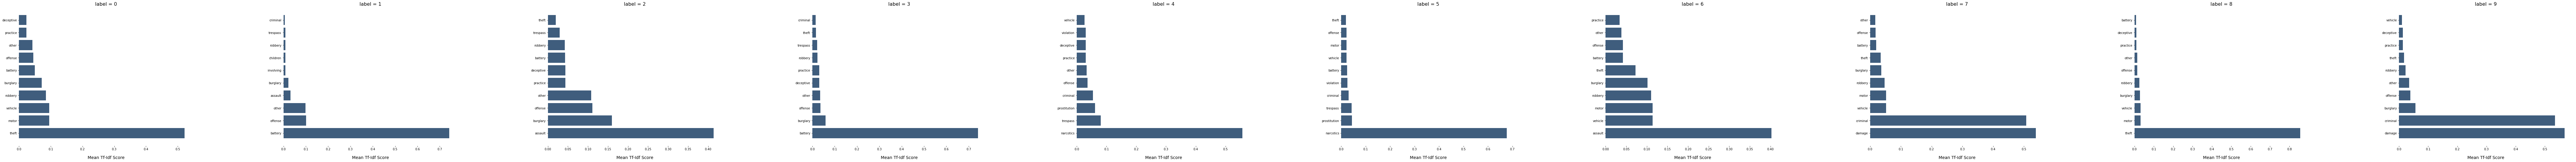

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,810,THEFT,OVER $500,STREET,False,False,5.0,2001.0,6,29,22
1,460,BATTERY,SIMPLE,RESIDENCE,False,True,25.0,2001.0,7,21,21
2,560,ASSAULT,SIMPLE,RESIDENCE,False,False,7.0,2001.0,2,6,17
3,460,BATTERY,SIMPLE,RESIDENCE,False,False,18.0,2001.0,12,4,9
4,2027,NARCOTICS,POSS: CRACK,STREET,True,False,2.0,2001.0,2,26,19
5,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,7.0,2001.0,4,18,20
6,560,ASSAULT,SIMPLE,STREET,False,False,14.0,2001.0,11,20,16
7,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,3.0,2001.0,5,6,0
8,820,THEFT,$500 AND UNDER,STREET,False,False,8.0,2001.0,1,19,15
9,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,10.0,2001.0,10,1,21


District
The test has an accuracy of: 
0.182444001407


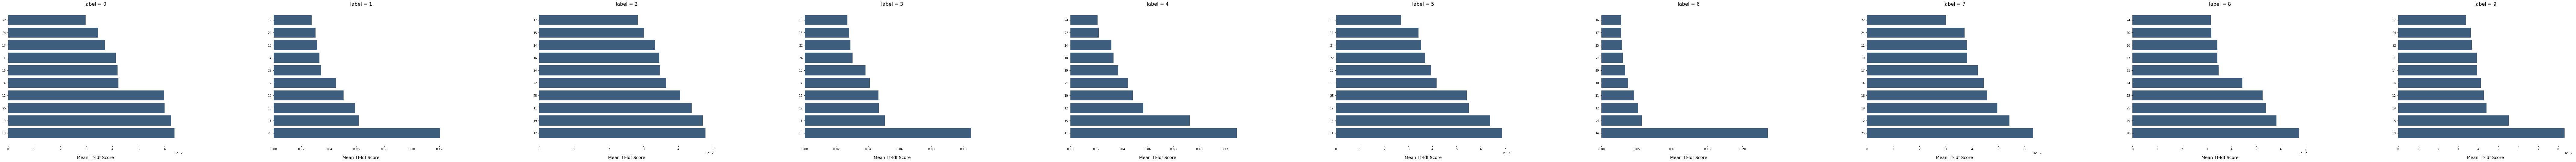

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,810,THEFT,OVER $500,STREET,False,False,5.0,2001.0,6,29,22
1,460,BATTERY,SIMPLE,RESIDENCE,False,True,25.0,2001.0,7,21,21
2,560,ASSAULT,SIMPLE,RESIDENCE,False,False,7.0,2001.0,2,6,17
3,460,BATTERY,SIMPLE,RESIDENCE,False,False,18.0,2001.0,12,4,9
4,2027,NARCOTICS,POSS: CRACK,STREET,True,False,2.0,2001.0,2,26,19
5,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,7.0,2001.0,4,18,20
6,560,ASSAULT,SIMPLE,STREET,False,False,14.0,2001.0,11,20,16
7,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,3.0,2001.0,5,6,0
8,820,THEFT,$500 AND UNDER,STREET,False,False,8.0,2001.0,1,19,15
9,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,10.0,2001.0,10,1,21


Day
The test has an accuracy of: 
0.168564559634


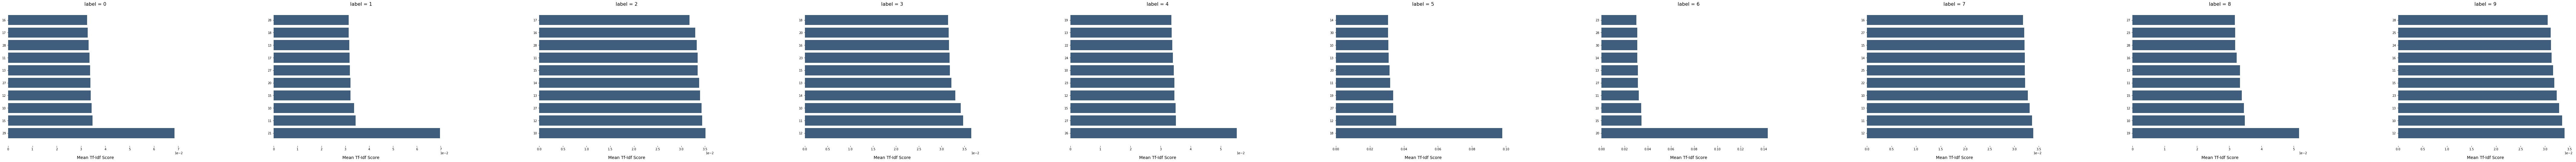

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,810,THEFT,OVER $500,STREET,False,False,5.0,2001.0,6,29,22
1,460,BATTERY,SIMPLE,RESIDENCE,False,True,25.0,2001.0,7,21,21
2,560,ASSAULT,SIMPLE,RESIDENCE,False,False,7.0,2001.0,2,6,17
3,460,BATTERY,SIMPLE,RESIDENCE,False,False,18.0,2001.0,12,4,9
4,2027,NARCOTICS,POSS: CRACK,STREET,True,False,2.0,2001.0,2,26,19
5,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,7.0,2001.0,4,18,20
6,560,ASSAULT,SIMPLE,STREET,False,False,14.0,2001.0,11,20,16
7,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,3.0,2001.0,5,6,0
8,820,THEFT,$500 AND UNDER,STREET,False,False,8.0,2001.0,1,19,15
9,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,10.0,2001.0,10,1,21


Hour
The test has an accuracy of: 
0.201254837575


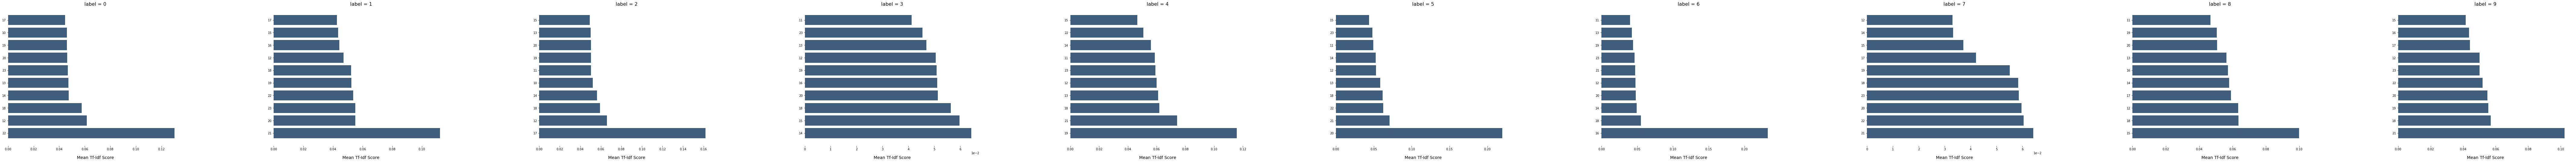

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,810,THEFT,OVER $500,STREET,False,False,5.0,2001.0,6,29,22
1,460,BATTERY,SIMPLE,RESIDENCE,False,True,25.0,2001.0,7,21,21
2,560,ASSAULT,SIMPLE,RESIDENCE,False,False,7.0,2001.0,2,6,17
3,460,BATTERY,SIMPLE,RESIDENCE,False,False,18.0,2001.0,12,4,9
4,2027,NARCOTICS,POSS: CRACK,STREET,True,False,2.0,2001.0,2,26,19
5,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,7.0,2001.0,4,18,20
6,560,ASSAULT,SIMPLE,STREET,False,False,14.0,2001.0,11,20,16
7,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,3.0,2001.0,5,6,0
8,820,THEFT,$500 AND UNDER,STREET,False,False,8.0,2001.0,1,19,15
9,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,10.0,2001.0,10,1,21


In [72]:
getTfidf(2001)

   IUCR                Primary Type                     Description  \
0  0266         CRIM SEXUAL ASSAULT                       PREDATORY   
1  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   
2  1752  OFFENSE INVOLVING CHILDREN   AGG CRIM SEX ABUSE FAM MEMBER   
3  1754  OFFENSE INVOLVING CHILDREN  AGG SEX ASSLT OF CHILD FAM MBR   
4  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0            APARTMENT  False    False      14.0  2002.0      6   14    16   
1            RESIDENCE  False    False      10.0  2002.0      7    1     0   
2            RESIDENCE  False    False      25.0  2002.0      1    1     0   
3          HOTEL/MOTEL  False     True      18.0  2002.0      1    1     0   
4                 BANK  False    False       4.0  2002.0      1    9    12   

   index.1  clusters_10  
0        0            0  
1        1            5  
2        2            5  


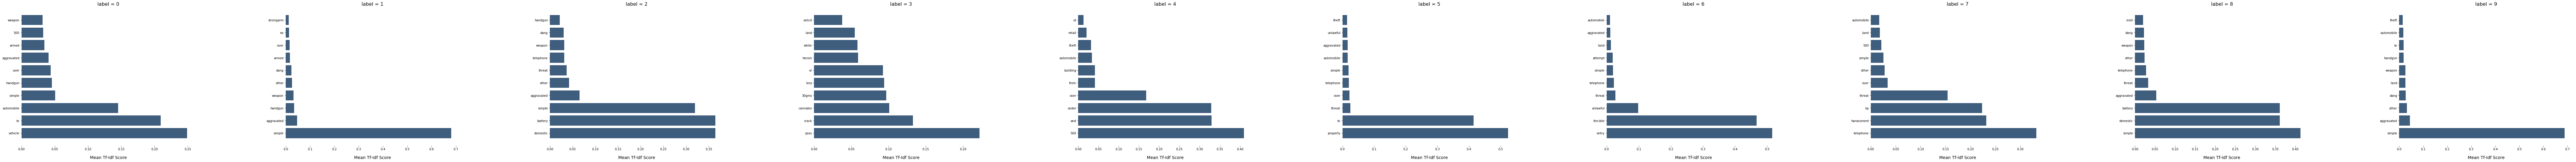

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,8.0,2002.0,7,13,16
1,460,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2002.0,8,3,10
2,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,8.0,2002.0,5,8,14
3,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2002.0,5,30,18
4,820,THEFT,$500 AND UNDER,STREET,False,False,2.0,2002.0,8,14,20
5,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,14.0,2002.0,2,2,0
6,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,3.0,2002.0,8,7,17
7,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,18.0,2002.0,6,18,12
8,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2.0,2002.0,3,24,18
9,460,BATTERY,SIMPLE,STREET,True,False,17.0,2002.0,5,15,9


Location Description
The test has an accuracy of: 
0.328862303159


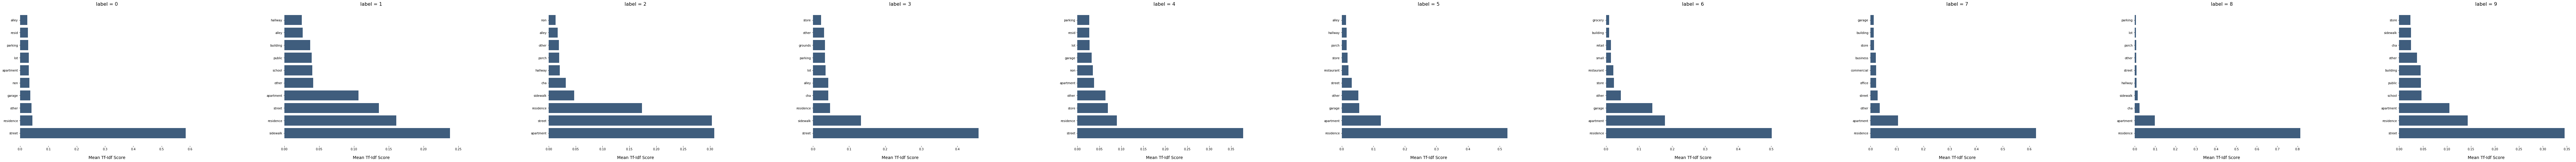

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,8.0,2002.0,7,13,16
1,460,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2002.0,8,3,10
2,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,8.0,2002.0,5,8,14
3,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2002.0,5,30,18
4,820,THEFT,$500 AND UNDER,STREET,False,False,2.0,2002.0,8,14,20
5,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,14.0,2002.0,2,2,0
6,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,3.0,2002.0,8,7,17
7,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,18.0,2002.0,6,18,12
8,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2.0,2002.0,3,24,18
9,460,BATTERY,SIMPLE,STREET,True,False,17.0,2002.0,5,15,9


Primary Type
The test has an accuracy of: 
0.607331945068


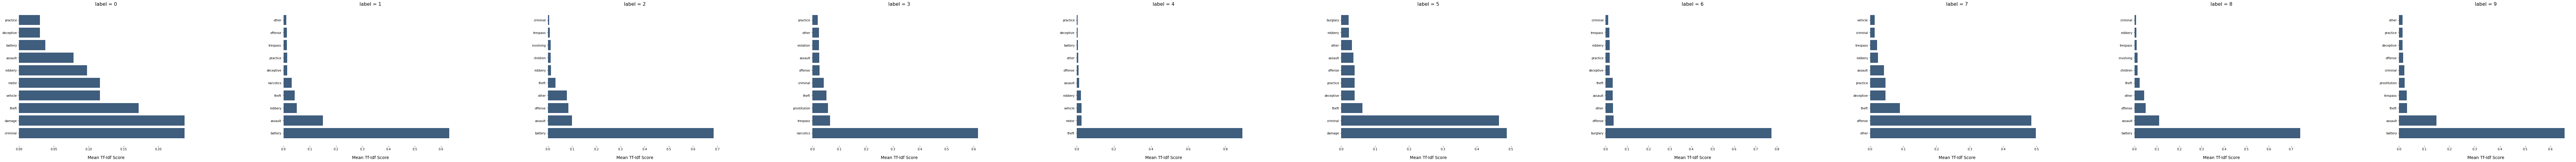

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,8.0,2002.0,7,13,16
1,460,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2002.0,8,3,10
2,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,8.0,2002.0,5,8,14
3,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2002.0,5,30,18
4,820,THEFT,$500 AND UNDER,STREET,False,False,2.0,2002.0,8,14,20
5,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,14.0,2002.0,2,2,0
6,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,3.0,2002.0,8,7,17
7,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,18.0,2002.0,6,18,12
8,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2.0,2002.0,3,24,18
9,460,BATTERY,SIMPLE,STREET,True,False,17.0,2002.0,5,15,9


District
The test has an accuracy of: 
0.227702693506


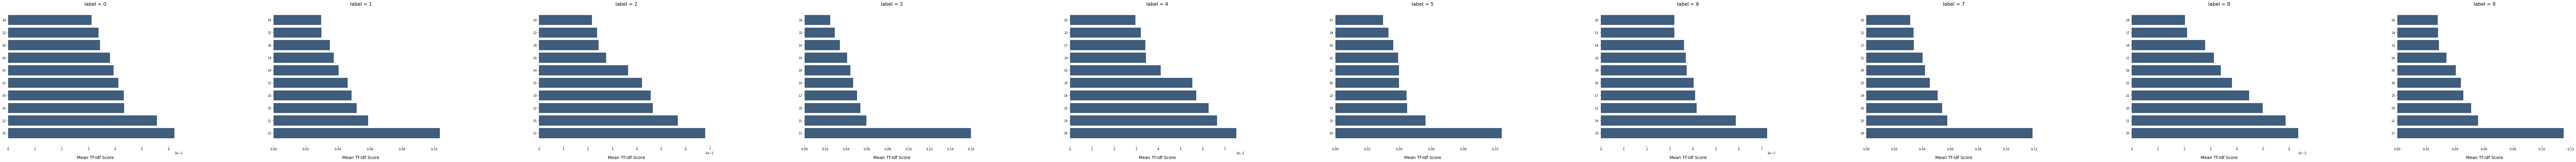

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,8.0,2002.0,7,13,16
1,460,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2002.0,8,3,10
2,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,8.0,2002.0,5,8,14
3,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2002.0,5,30,18
4,820,THEFT,$500 AND UNDER,STREET,False,False,2.0,2002.0,8,14,20
5,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,14.0,2002.0,2,2,0
6,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,3.0,2002.0,8,7,17
7,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,18.0,2002.0,6,18,12
8,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2.0,2002.0,3,24,18
9,460,BATTERY,SIMPLE,STREET,True,False,17.0,2002.0,5,15,9


Day
The test has an accuracy of: 
0.193989628843


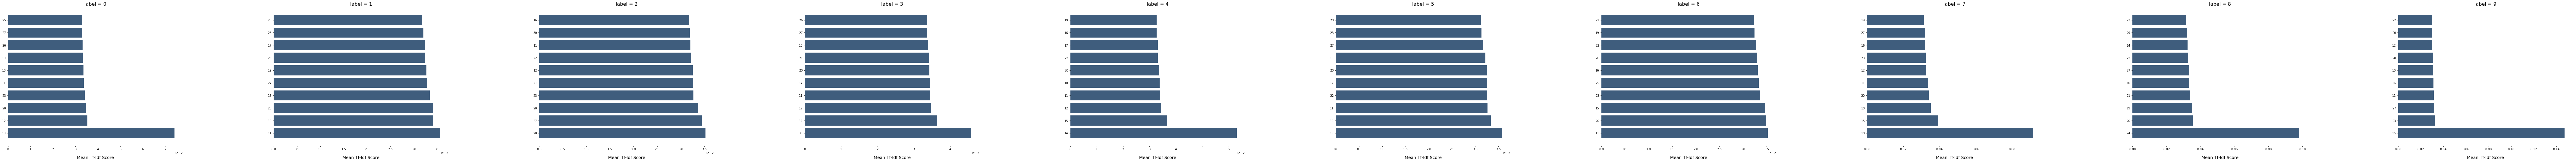

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,8.0,2002.0,7,13,16
1,460,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2002.0,8,3,10
2,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,8.0,2002.0,5,8,14
3,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2002.0,5,30,18
4,820,THEFT,$500 AND UNDER,STREET,False,False,2.0,2002.0,8,14,20
5,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,14.0,2002.0,2,2,0
6,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,3.0,2002.0,8,7,17
7,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,18.0,2002.0,6,18,12
8,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2.0,2002.0,3,24,18
9,460,BATTERY,SIMPLE,STREET,True,False,17.0,2002.0,5,15,9


Hour
The test has an accuracy of: 
0.23090114736


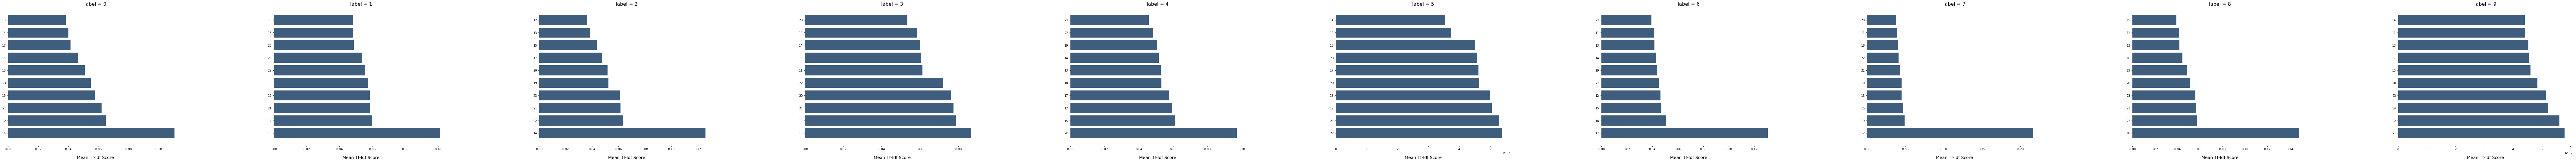

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,8.0,2002.0,7,13,16
1,460,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2002.0,8,3,10
2,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,8.0,2002.0,5,8,14
3,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2002.0,5,30,18
4,820,THEFT,$500 AND UNDER,STREET,False,False,2.0,2002.0,8,14,20
5,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,14.0,2002.0,2,2,0
6,610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,3.0,2002.0,8,7,17
7,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,18.0,2002.0,6,18,12
8,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2.0,2002.0,3,24,18
9,460,BATTERY,SIMPLE,STREET,True,False,17.0,2002.0,5,15,9


In [73]:
getTfidf(2002)

   IUCR   Primary Type                     Description  \
0  2825  OTHER OFFENSE         HARASSMENT BY TELEPHONE   
1  0841          THEFT  FINANCIAL ID THEFT:$300 &UNDER   
2  5007  OTHER OFFENSE         OTHER WEAPONS VIOLATION   
3  0840          THEFT   FINANCIAL ID THEFT: OVER $300   
4  0840          THEFT   FINANCIAL ID THEFT: OVER $300   

      Location Description Arrest Domestic  District    Year  Month  Day  \
0                RESIDENCE  False     True       9.0  2003.0      3    1   
1                RESIDENCE  False    False      22.0  2003.0      5    1   
2  RESIDENCE PORCH/HALLWAY  False    False      22.0  2003.0      3   15   
3                RESIDENCE  False    False      11.0  2003.0      1    1   
4                RESIDENCE  False    False      22.0  2003.0      6    5   

   Hour  index.1  clusters_10  
0     0        0            3  
1     1        1            4  
2     0        2            0  
3     0        3            7  
4     0        4            7  
(4

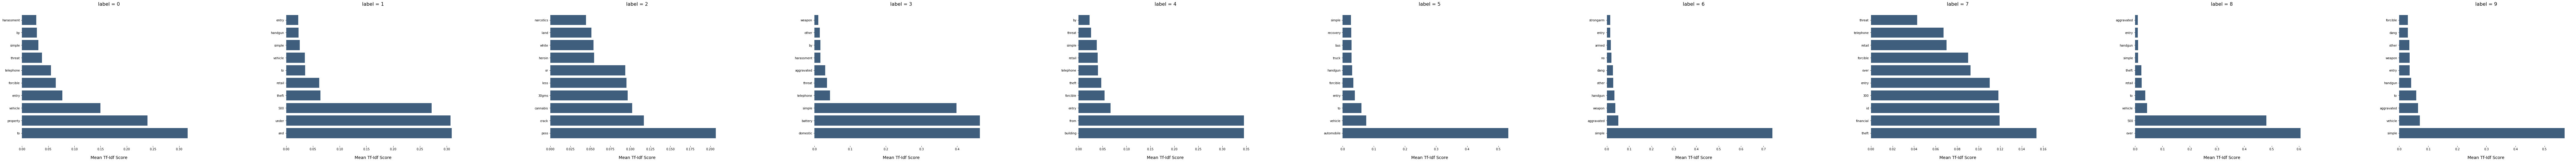

,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Month,Day,Hour
0,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,16.0,2003.0,1,16,23
1,820,THEFT,$500 AND UNDER,STREET,False,False,1.0,2003.0,10,19,9
2,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,11.0,2003.0,11,5,20
3,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,7.0,2003.0,7,20,18
4,890,THEFT,FROM BUILDING,RESIDENCE,False,False,12.0,2003.0,8,18,12
5,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,6.0,2003.0,11,15,21
6,460,BATTERY,SIMPLE,SIDEWALK,False,False,7.0,2003.0,11,7,14
7,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,8.0,2003.0,9,2,0
8,810,THEFT,OVER $500,STREET,False,False,12.0,2003.0,10,29,14
9,460,BATTERY,SIMPLE,STREET,False,False,9.0,2003.0,5,17,18


In [68]:
getTfidf(2003)

In [100]:
getTfidf(2004)

56851.7